<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/heteroskedasticGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 12.7 MB/s eta 0:00:00


In [ ]:
import gpax
gpax.utils.enable_x64()

In [ ]:
"""
hsk_gp.py
=========

Fully Bayesian implementation of heteroskedastic Gaussian process regression

Created by Maxim Ziatdinov (email: maxim.ziatdinov@gmail.com)
"""

import warnings
from functools import partial
from typing import Callable, Dict, Optional, Tuple, Type, Union

import jax
import jaxlib
import jax.numpy as jnp
import jax.random as jra
import numpyro
import numpyro.distributions as dist
from jax import jit
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive

from gpax.kernels import get_kernel
from gpax.utils import split_in_batches

kernel_fn_type = Callable[[jnp.ndarray, jnp.ndarray, Dict[str, jnp.ndarray], jnp.ndarray], jnp.ndarray]

clear_cache = jax._src.dispatch.xla_primitive_callable.cache_clear


class hskGP:
    """
    Heteroskedastic Gaussian process class

    Args:
        input_dim:
            Number of input dimensions
        kernel:
            Main kernel function ('RBF', 'Matern', 'Periodic', or custom function)
        noise_kernel:
            Noise kernel function ('RBF', 'Matern', 'Periodic', or custom function)
        mean_fn:
            Optional deterministic mean function (use 'mean_fn_priors' to make it probabilistic)
        kernel_prior:
            Optional custom priors over main kernel hyperparameters. Use it when passing your custom kernel.
        mean_fn_prior:
            Optional priors over mean function parameters
        lengthscale_prior_dist:
            Optional custom prior distribution over main kernel lengthscale. Defaults to LogNormal(0, 1).
        noise_lengthscale_prior_dist:
            Optional custom prior distribution over noise kernel lengthscale. Defaults to LogNormal(0, 1).
    """

    def __init__(
        self,
        input_dim: int,
        kernel: Union[str, kernel_fn_type],
        noise_kernel: Union[str, kernel_fn_type] = 'RBF',
        mean_fn: Optional[Callable[[jnp.ndarray, Dict[str, jnp.ndarray]], jnp.ndarray]] = None,
        kernel_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
        mean_fn_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
        noise_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
        noise_lengthscale_prior_dist: Optional[dist.Distribution] = None,
        lengthscale_prior_dist: Optional[dist.Distribution] = None,
    ) -> None:
        clear_cache()
        self.kernel_dim = input_dim
        self.kernel = get_kernel(kernel)
        self.kernel_name = kernel if isinstance(kernel, str) else None
        self.noise_kernel = get_kernel(kernel)
        self.mean_fn = mean_fn
        self.kernel_prior = kernel_prior
        self.mean_fn_prior = mean_fn_prior
        self.noise_prior = noise_prior
        self.lengthscale_prior_dist = lengthscale_prior_dist
        self.noise_lengthscale_prior_dist = noise_lengthscale_prior_dist
        self.X_train = None
        self.y_train = None
        self.mcmc = None

    def model(self, X: jnp.ndarray, y: jnp.ndarray = None, **kwargs: float) -> None:
        """GP probabilistic model with inputs X and targets y"""
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])

        # Sample noise kernel parameters
        noise_kernel_params = self._sample_noise_kernel_params()
        # Compute noise kernel
        k_noise = self.noise_kernel(X, X, noise_kernel_params, 0, **kwargs)
        # Compute log variance of the data points
        points_log_var = numpyro.sample(
            "log_var",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k_noise)
        )

        # Sample main kernel parameters
        if self.kernel_prior:
            kernel_params = self.kernel_prior()
        else:
            kernel_params = self._sample_kernel_params()
        # Add mean function (if any)
        if self.mean_fn is not None:
            args = [X]
            if self.mean_fn_prior is not None:
                args += [self.mean_fn_prior()]
            f_loc += self.mean_fn(*args).squeeze()
        # compute main kernel
        k = self.kernel(X, X, kernel_params, 0, **kwargs)
        # Sample y according to the standard Gaussian process formula. Note that instead of adding a fixed noise term to the kernel,
        # we exponentiate the log_var samples to get the variance at each data point
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k+jnp.diag(jnp.exp(points_log_var))),
            obs=y,
        )

    def fit(
        self,
        rng_key: jnp.array,
        X: jnp.ndarray,
        y: jnp.ndarray,
        num_warmup: int = 2000,
        num_samples: int = 2000,
        num_chains: int = 1,
        chain_method: str = "sequential",
        progress_bar: bool = True,
        print_summary: bool = True,
        device: Type[jaxlib.xla_extension.Device] = None,
        **kwargs: float
    ) -> None:
        """
        Run Hamiltonian Monter Carlo to infer the GP parameters

        Args:
            rng_key: random number generator key
            X: 2D feature vector
            y: 1D target vector
            num_warmup: number of HMC warmup states
            num_samples: number of HMC samples
            num_chains: number of HMC chains
            chain_method: 'sequential', 'parallel' or 'vectorized'
            progress_bar: show progress bar
            print_summary: print summary at the end of sampling
            device:
                optionally specify a cpu or gpu device on which to run the inference;
                e.g., ``device=jax.devices("cpu")[0]``
            **jitter:
                Small positive term added to the diagonal part of a covariance
                matrix for numerical stability (Default: 1e-6)
        """
        X, y = self._set_data(X, y)
        if device:
            X = jax.device_put(X, device)
            y = jax.device_put(y, device)
        self.X_train = X
        self.y_train = y

        init_strategy = init_to_median(num_samples=10)
        kernel = NUTS(self.model, init_strategy=init_strategy)
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            chain_method=chain_method,
            progress_bar=progress_bar,
            jit_model_args=False,
        )
        self.mcmc.run(rng_key, X, y, **kwargs)
        if print_summary:
            self._print_summary()

    def _sample_noise(self) -> jnp.ndarray:
        if self.noise_prior_dist is not None:
            noise_dist = self.noise_prior_dist
        else:
            noise_dist = dist.LogNormal(0, 1)
        return numpyro.sample("noise", noise_dist)

    def _sample_kernel_params(self, output_scale=True) -> Dict[str, jnp.ndarray]:
        """
        Sample kernel parameters with default
        weakly-informative log-normal priors
        """
        if self.lengthscale_prior_dist is not None:
            length_dist = self.lengthscale_prior_dist
        else:
            length_dist = dist.LogNormal(0.0, 1.0)
        with numpyro.plate("ard", self.kernel_dim):  # allows using ARD kernel for kernel_dim > 1
            length = numpyro.sample("k_length", length_dist)
        if output_scale:
            scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1.0))
        else:
            scale = numpyro.deterministic("k_scale", jnp.array(1.0))
        if self.kernel_name == "Periodic":
            period = numpyro.sample("period", dist.LogNormal(0.0, 1.0))
        kernel_params = {"k_length": length, "k_scale": scale, "period": period if self.kernel_name == "Periodic" else None}
        return kernel_params

    def _sample_noise_kernel_params(self) -> Dict[str, jnp.ndarray]:
        """
        Sample noise kernel parameters
        """
        if self.noise_lengthscale_prior_dist is not None:
            noise_length_dist = self.noise_lengthscale_prior_dist
        else:
            noise_length_dist = dist.HalfNormal(1.0)
        noise_scale = numpyro.sample("k_noise_scale", dist.HalfNormal(1.0))
        noise_length = numpyro.sample("k_noise_length", noise_length_dist)
        return {"k_length": noise_length, "k_scale": noise_scale}

    def get_samples(self, chain_dim: bool = False) -> Dict[str, jnp.ndarray]:
        """Get posterior samples (after running the MCMC chains)"""
        return self.mcmc.get_samples(group_by_chain=chain_dim)

    # @partial(jit, static_argnames='self')
    def get_mvn_posterior(
        self, X_new: jnp.ndarray, params: Dict[str, jnp.ndarray], noiseless: bool = False, **kwargs: float
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Returns parameters (mean and cov) of multivariate normal posterior
        for a single sample of GP parameters
        """
        ### Main GP part ###
        y_residual = self.y_train.copy()
        if self.mean_fn is not None:
            args = [self.X_train, params] if self.mean_fn_prior else [self.X_train]
            y_residual -= self.mean_fn(*args).squeeze()
        # compute main kernel matrices for train and test data
        k_pp = self.kernel(X_new, X_new, params, 0, **kwargs)
        k_pX = self.kernel(X_new, self.X_train, params, jitter=0.0)
        k_XX = self.kernel(self.X_train, self.X_train, params, 0, **kwargs)
        # compute the predictive covariance and mean
        K_xx_inv = jnp.linalg.inv(k_XX)
        cov = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, y_residual))
        if self.mean_fn is not None:
            args = [X_new, params] if self.mean_fn_prior else [X_new]
            mean += self.mean_fn(*args).squeeze()

        ### Noise GP part ###
        # Compute noise kernel matrices
        k_pX_noise = self.noise_kernel(
            X_new, self.X_train,
            {"k_length": params["k_noise_length"], "k_scale": params["k_noise_scale"]},
            jitter=0.0)
        k_XX_noise = self.noise_kernel(
            self.X_train, self.X_train,
            {"k_length": params["k_noise_length"], "k_scale": params["k_noise_scale"]},
            0, **kwargs)
        # Compute noise predictive mean
        K_xx_noise_inv = jnp.linalg.inv(k_XX_noise)
        predicted_log_var = jnp.matmul(k_pX_noise, jnp.matmul(K_xx_noise_inv, params["log_var"]))
        predicted_noise_variance = jnp.exp(predicted_log_var)

        # Return the main GP's predictive mean and combined (main + noise) covariance matrix
        return mean, cov + jnp.diag(predicted_noise_variance)

    def _predict(
        self,
        rng_key: jnp.ndarray,
        X_new: jnp.ndarray,
        params: Dict[str, jnp.ndarray],
        n: int,
        noiseless: bool = False,
        **kwargs: float
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """Prediction with a single sample of GP parameters"""
        # Get the predictive mean and covariance
        y_mean, K = self.get_mvn_posterior(X_new, params, noiseless, **kwargs)
        # draw samples from the posterior predictive for a given set of parameters
        y_sampled = dist.MultivariateNormal(y_mean, K).sample(rng_key, sample_shape=(n,))
        return y_mean, y_sampled

    def _predict_in_batches(
        self,
        rng_key: jnp.ndarray,
        X_new: jnp.ndarray,
        batch_size: int = 100,
        batch_dim: int = 0,
        samples: Optional[Dict[str, jnp.ndarray]] = None,
        n: int = 1,
        filter_nans: bool = False,
        predict_fn: Callable[[jnp.ndarray, int], Tuple[jnp.ndarray]] = None,
        noiseless: bool = False,
        device: Type[jaxlib.xla_extension.Device] = None,
        **kwargs: float
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if predict_fn is None:
            predict_fn = lambda xi: self.predict(rng_key, xi, samples, n, filter_nans, noiseless, device, **kwargs)

        def predict_batch(Xi):
            out1, out2 = predict_fn(Xi)
            out1 = jax.device_put(out1, jax.devices("cpu")[0])
            out2 = jax.device_put(out2, jax.devices("cpu")[0])
            return out1, out2

        y_out1, y_out2 = [], []
        for Xi in split_in_batches(X_new, batch_size, dim=batch_dim):
            out1, out2 = predict_batch(Xi)
            y_out1.append(out1)
            y_out2.append(out2)
        return y_out1, y_out2

    def predict_in_batches(
        self,
        rng_key: jnp.ndarray,
        X_new: jnp.ndarray,
        batch_size: int = 100,
        samples: Optional[Dict[str, jnp.ndarray]] = None,
        n: int = 1,
        filter_nans: bool = False,
        predict_fn: Callable[[jnp.ndarray, int], Tuple[jnp.ndarray]] = None,
        noiseless: bool = False,
        device: Type[jaxlib.xla_extension.Device] = None,
        **kwargs: float
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Make prediction at X_new with sampled GP parameters
        by spitting the input array into chunks ("batches") and running
        predict_fn (defaults to self.predict) on each of them one-by-one
        to avoid a memory overflow
        """
        y_pred, y_sampled = self._predict_in_batches(
            rng_key, X_new, batch_size, 0, samples, n, filter_nans, predict_fn, noiseless, device, **kwargs
        )
        y_pred = jnp.concatenate(y_pred, 0)
        y_sampled = jnp.concatenate(y_sampled, -1)
        return y_pred, y_sampled

    def predict(
        self,
        rng_key: jnp.ndarray,
        X_new: jnp.ndarray,
        samples: Optional[Dict[str, jnp.ndarray]] = None,
        n: int = 1,
        filter_nans: bool = False,
        noiseless: bool = False,
        device: Type[jaxlib.xla_extension.Device] = None,
        **kwargs: float
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Make prediction at X_new points using posterior samples for GP parameters

        Args:
            rng_key: random number generator key
            X_new: new inputs with *(number of points, number of features)* dimensions
            samples: optional (different) samples with GP parameters
            n: number of samples from Multivariate Normal posterior for each HMC sample with GP parameters
            filter_nans: filter out samples containing NaN values (if any)
            noiseless:
                Noise-free prediction. It is set to False by default as new/unseen data is assumed
                to follow the same distribution as the training data. Hence, since we introduce a model noise
                by default for the training data, we also want to include that noise in our prediction.
            device:
                optionally specify a cpu or gpu device on which to make a prediction;
                e.g., ```device=jax.devices("gpu")[0]```
            **jitter:
                Small positive term added to the diagonal part of a covariance
                matrix for numerical stability (Default: 1e-6)

        Returns
            Center of the mass of sampled means and all the sampled predictions
        """
        X_new = self._set_data(X_new)
        if samples is None:
            samples = self.get_samples(chain_dim=False)
        if device:
            self._set_training_data(device=device)
            X_new = jax.device_put(X_new, device)
            samples = jax.device_put(samples, device)
        num_samples = len(next(iter(samples.values())))
        vmap_args = (jra.split(rng_key, num_samples), samples)
        predictive = jax.vmap(lambda prms: self._predict(prms[0], X_new, prms[1], n, noiseless, **kwargs))
        y_means, y_sampled = predictive(vmap_args)
        if filter_nans:
            y_sampled_ = [y_i for y_i in y_sampled if not jnp.isnan(y_i).any()]
            y_sampled = jnp.array(y_sampled_)
        return y_means.mean(0), y_sampled

    def sample_from_prior(self, rng_key: jnp.ndarray, X: jnp.ndarray, num_samples: int = 10):
        """
        Samples from prior predictive distribution at X
        """
        X = self._set_data(X)
        prior_predictive = Predictive(self.model, num_samples=num_samples)
        samples = prior_predictive(rng_key, X)
        return samples["y"]

    def get_data_var_samples(self):
        """Returns inferred (training) data variance samples"""
        samples = model.get_samples()
        return jnp.exp(samples["log_var"])

    def _set_data(self, X: jnp.ndarray, y: Optional[jnp.ndarray] = None) -> Union[Tuple[jnp.ndarray], jnp.ndarray]:
        X = X if X.ndim > 1 else X[:, None]
        if y is not None:
            return X, y.squeeze()
        return X

    def _set_training_data(
        self,
        X_train_new: jnp.ndarray = None,
        y_train_new: jnp.ndarray = None,
        device: Type[jaxlib.xla_extension.Device] = None,
    ) -> None:
        X_train = self.X_train if X_train_new is None else X_train_new
        y_train = self.y_train if y_train_new is None else y_train_new
        if device:
            X_train = jax.device_put(X_train, device)
            y_train = jax.device_put(y_train, device)
        self.X_train = X_train
        self.y_train = y_train

    def _print_summary(self):
        samples = self.get_samples(1)
        numpyro.diagnostics.print_summary({k: v for (k, v) in samples.items() if 'log_var' not in k})


## Example 1 - apply as is

Make some toy data:

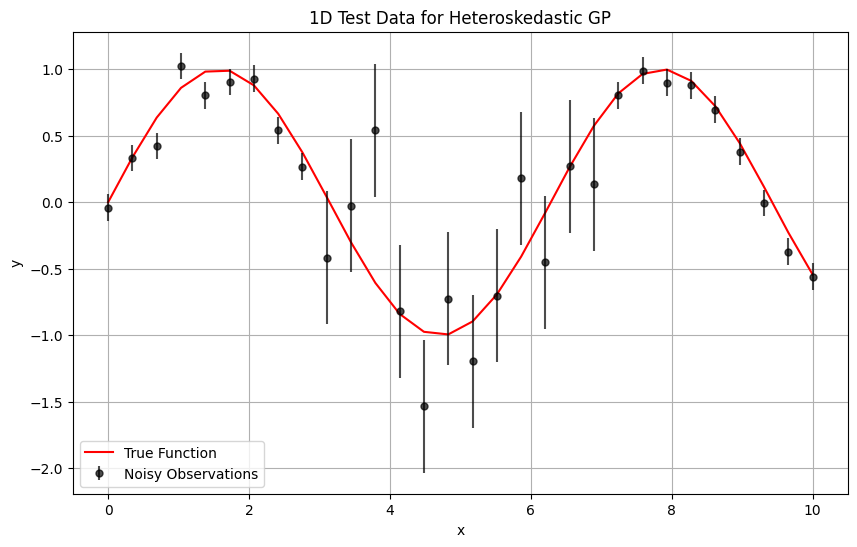

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

# Define the true function
def true_function(x):
    return np.sin(x)

# Generate x data: Less points now, let's say 20 in total
X = np.linspace(0, 10, 30)

# True y data without noise
y_true = true_function(X)

# Generate heteroskedastic noise
noise_level = np.where((X > 3) & (X < 7), 0.5, 0.1)
noise = np.random.randn(X.size) * noise_level

# Noisy y data
y_noisy = y_true + noise

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(X, y_true, 'r', label="True Function")
plt.errorbar(X, y_noisy, noise_level, fmt='.', c='k', markersize=10, label="Noisy Observations", alpha=0.7)
plt.title("1D Test Data for Heteroskedastic GP")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


Run GP:

In [ ]:
from gpax.utils import get_keys

key1, key2 = get_keys()

model = hskGP(1, 'RBF')

model.fit(key1, X, y_noisy, num_warmup=2000, num_samples=2000)

sample: 100%|██████████| 4000/4000 [08:00<00:00,  8.33it/s, 1023 steps of size 7.67e-04. acc. prob=0.84]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_length[0]      1.41      0.35      1.40      0.86      2.00     42.85      1.09
  k_noise_length      2.05      0.47      2.03      1.29      2.81     34.03      1.06
   k_noise_scale      2.38      0.59      2.36      1.35      3.28     61.67      1.00
         k_scale      0.82      0.80      0.59      0.16      1.54     56.22      1.07



Prediciton on a denser grid:

In [ ]:
X_test = np.linspace(0, 10, 100)

y_pred, y_sampled = model.predict(key2, X_test)

data_variance = model.get_data_var_samples().mean(0)

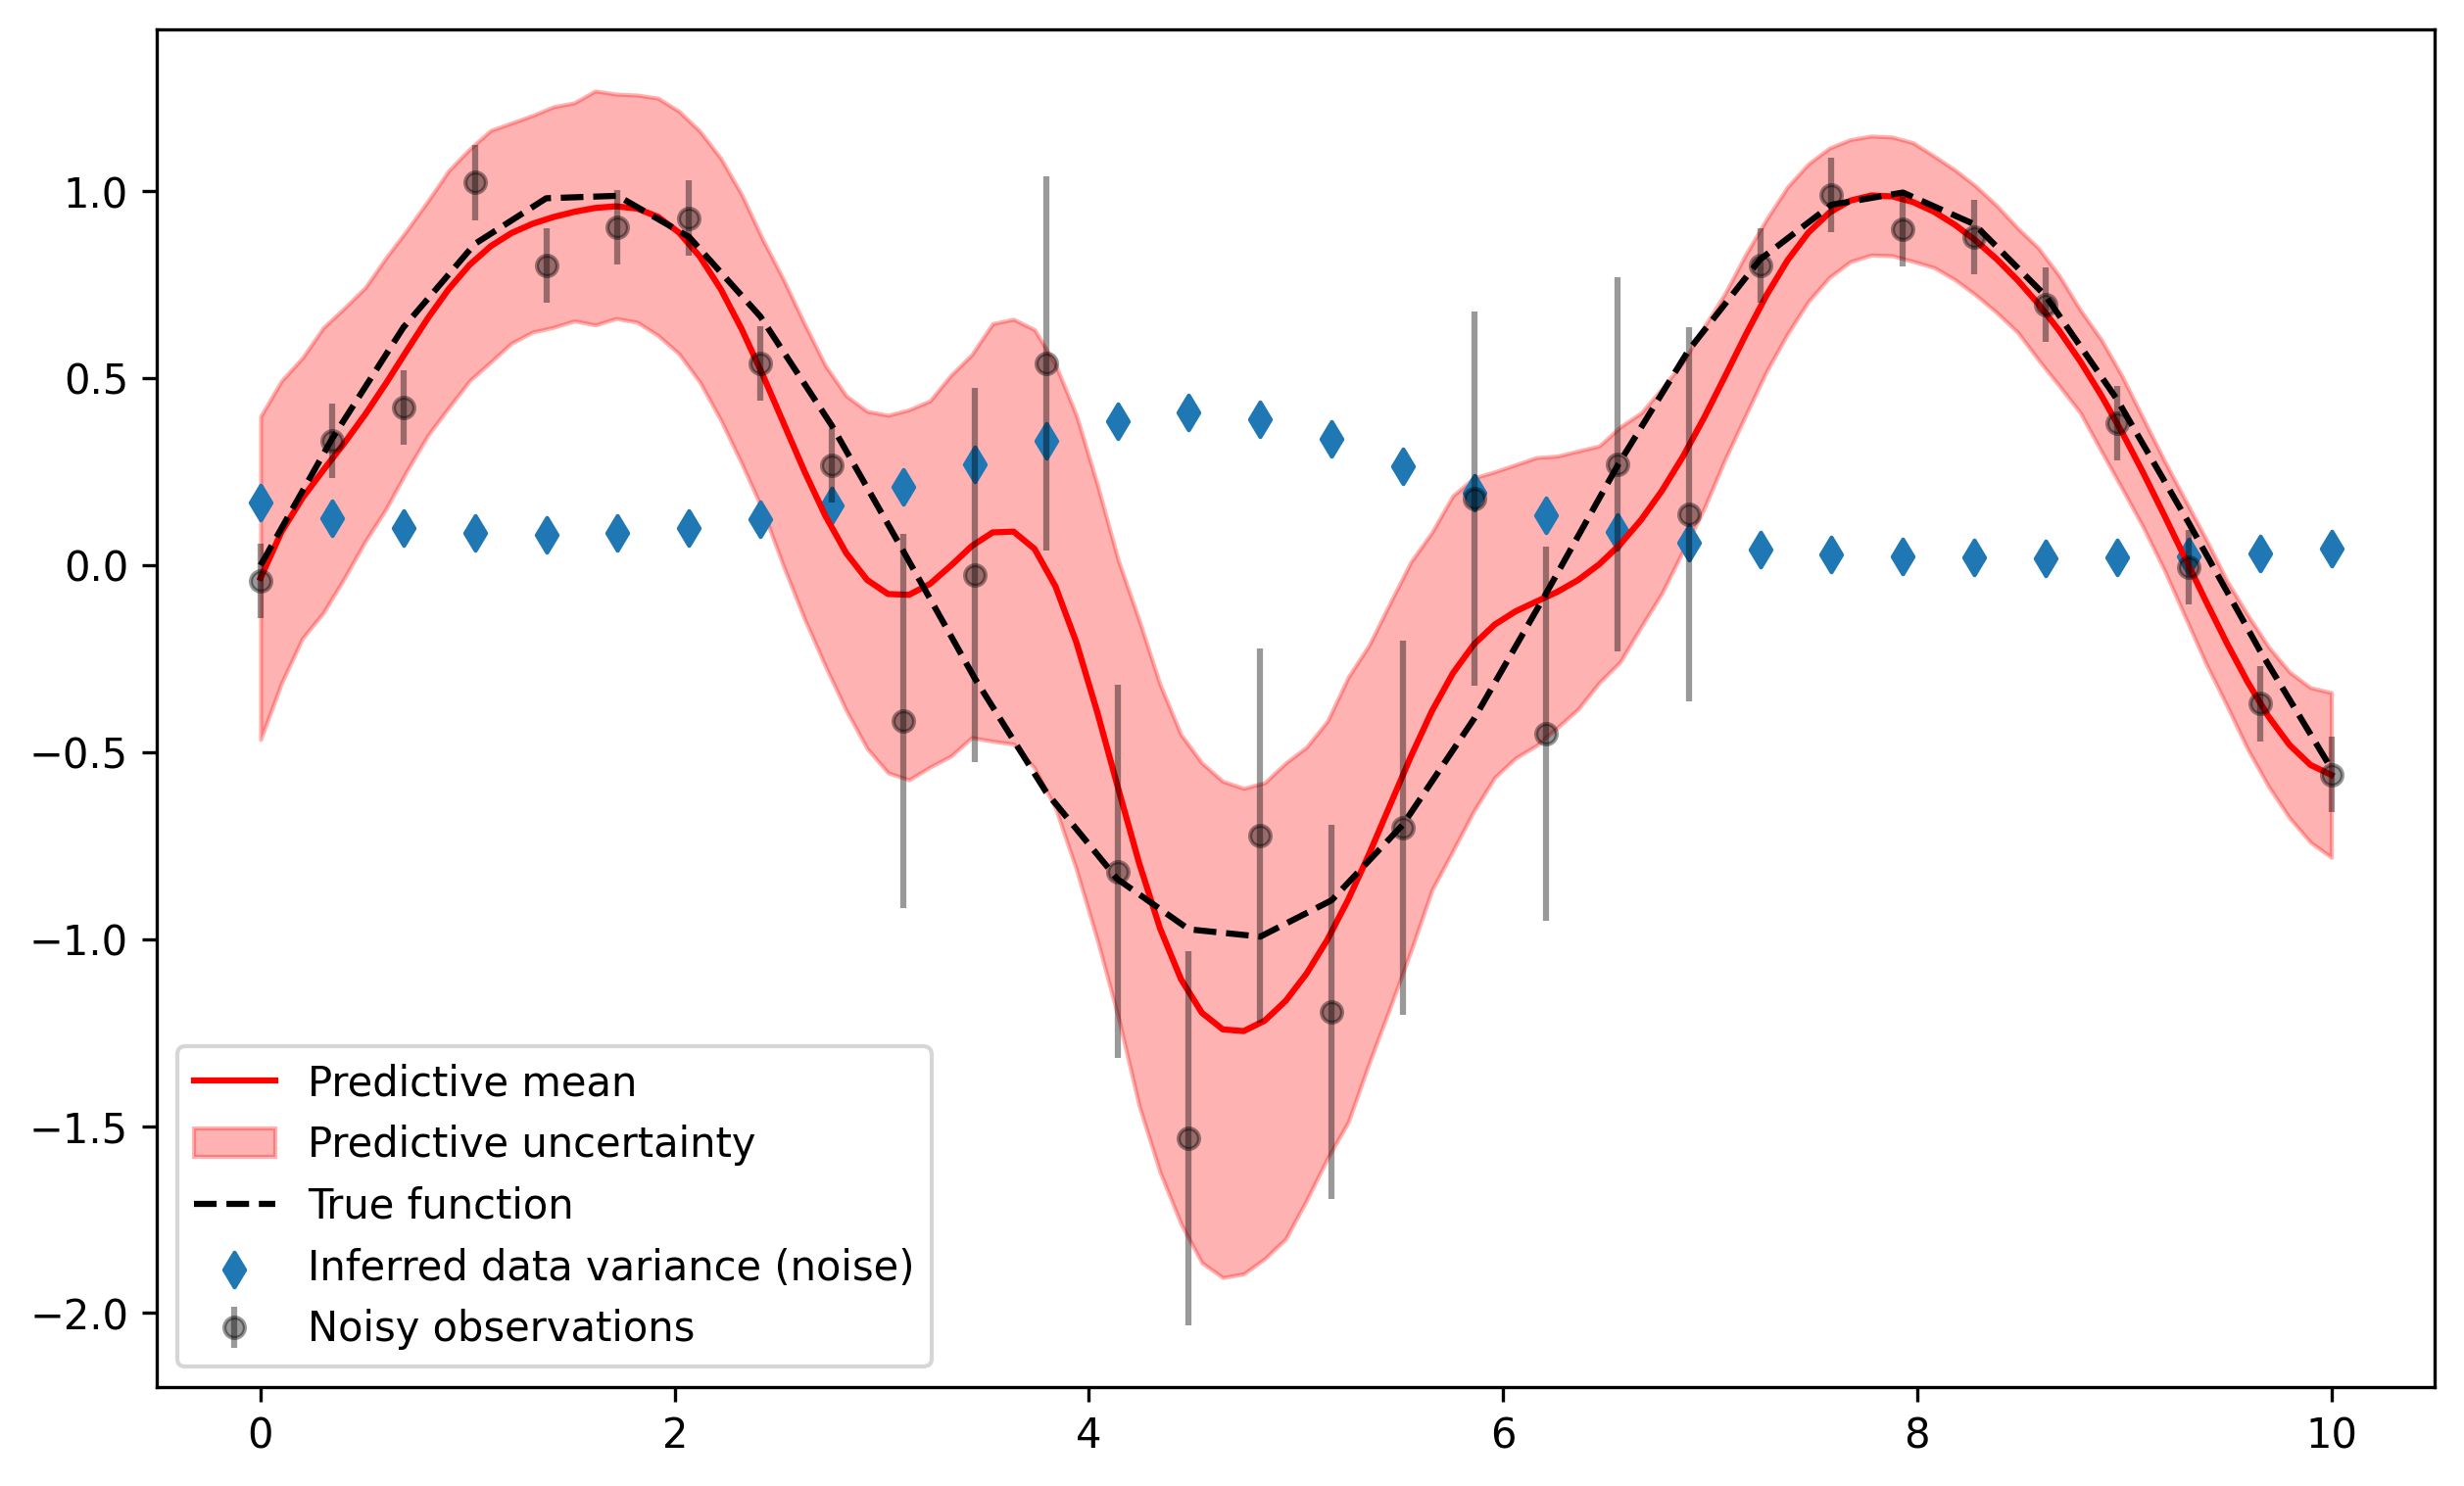

In [ ]:
lower_b = y_pred - y_sampled.std(axis=(0,1))
upper_b = y_pred + y_sampled.std(axis=(0,1))

plt.figure(figsize=(10, 6), dpi=300)

plt.plot(X_test, y_pred, c='r', label='Predictive mean')
plt.fill_between(X_test, lower_b, upper_b, color='r', alpha=0.3, label="Predictive uncertainty")

plt.errorbar(X, y_noisy, noise_level, fmt='.', c='k', markersize=10, alpha=0.4, label='Noisy observations')
plt.plot(X, y_true, '--', c='k', label='True function')

plt.scatter(X, data_variance, marker='d', label='Inferred data variance (noise)')

plt.legend(loc='best')

## Example 2 - add priors to data and noise kernels

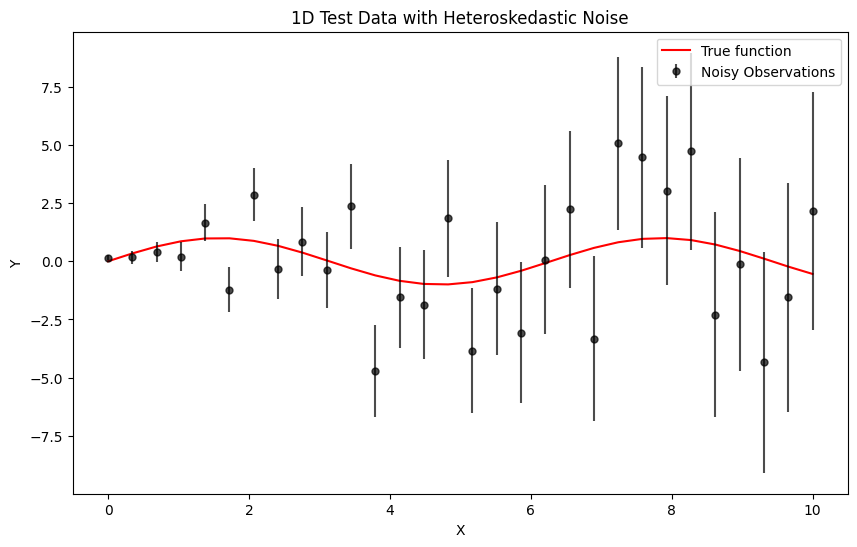

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(1)

# Generate data
N = 30
X = np.linspace(0, 10, N)[:, None]  # 1D column vector
y_true = np.sin(X)

# Create heteroskedastic noise: noise increases as x increases
noise_std = 0.1 + 0.5 * X
noise = np.random.randn(N, 1) * noise_std

# Observed data
y_noisy = y_true + noise

# Plotting
plt.figure(figsize=(10,6))
plt.plot(X, y_true, 'r', label='True function')
plt.errorbar(X.ravel(), y_noisy.ravel(), yerr=noise_std.ravel(), fmt='.', c='k', markersize=10, label="Noisy Observations", alpha=0.7)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('1D Test Data with Heteroskedastic Noise')
plt.show()


First, apply as is:

In [ ]:
key1, key2 = get_keys()

model = hskGP(1, 'RBF')

model.fit(key1, X, y_noisy, num_warmup=2000, num_samples=2000)

sample: 100%|██████████| 4000/4000 [03:02<00:00, 21.90it/s, 9 steps of size 1.51e-01. acc. prob=0.65]  



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_length[0]      0.16      0.08      0.15      0.08      0.23    266.56      1.00
  k_noise_length      0.22      0.12      0.22      0.02      0.40     56.17      1.15
   k_noise_scale      0.76      0.63      0.59      0.01      1.66     61.17      1.01
         k_scale      4.73      1.64      4.56      2.25      7.28    350.00      1.00



**Note a relatively large (larger than 1.1) ```r_hat``` value for ```k_noise_length``` - an indiciation that MCMC didn't converge properly and that we may need to adjust our priors. We can also go ahead and plot predictions, just to see how crappy they are.**

In [ ]:
X_test = np.linspace(0, 10, 100)

y_pred, y_sampled = model.predict(key2, X_test)

data_variance = model.get_data_var_samples().mean(0)

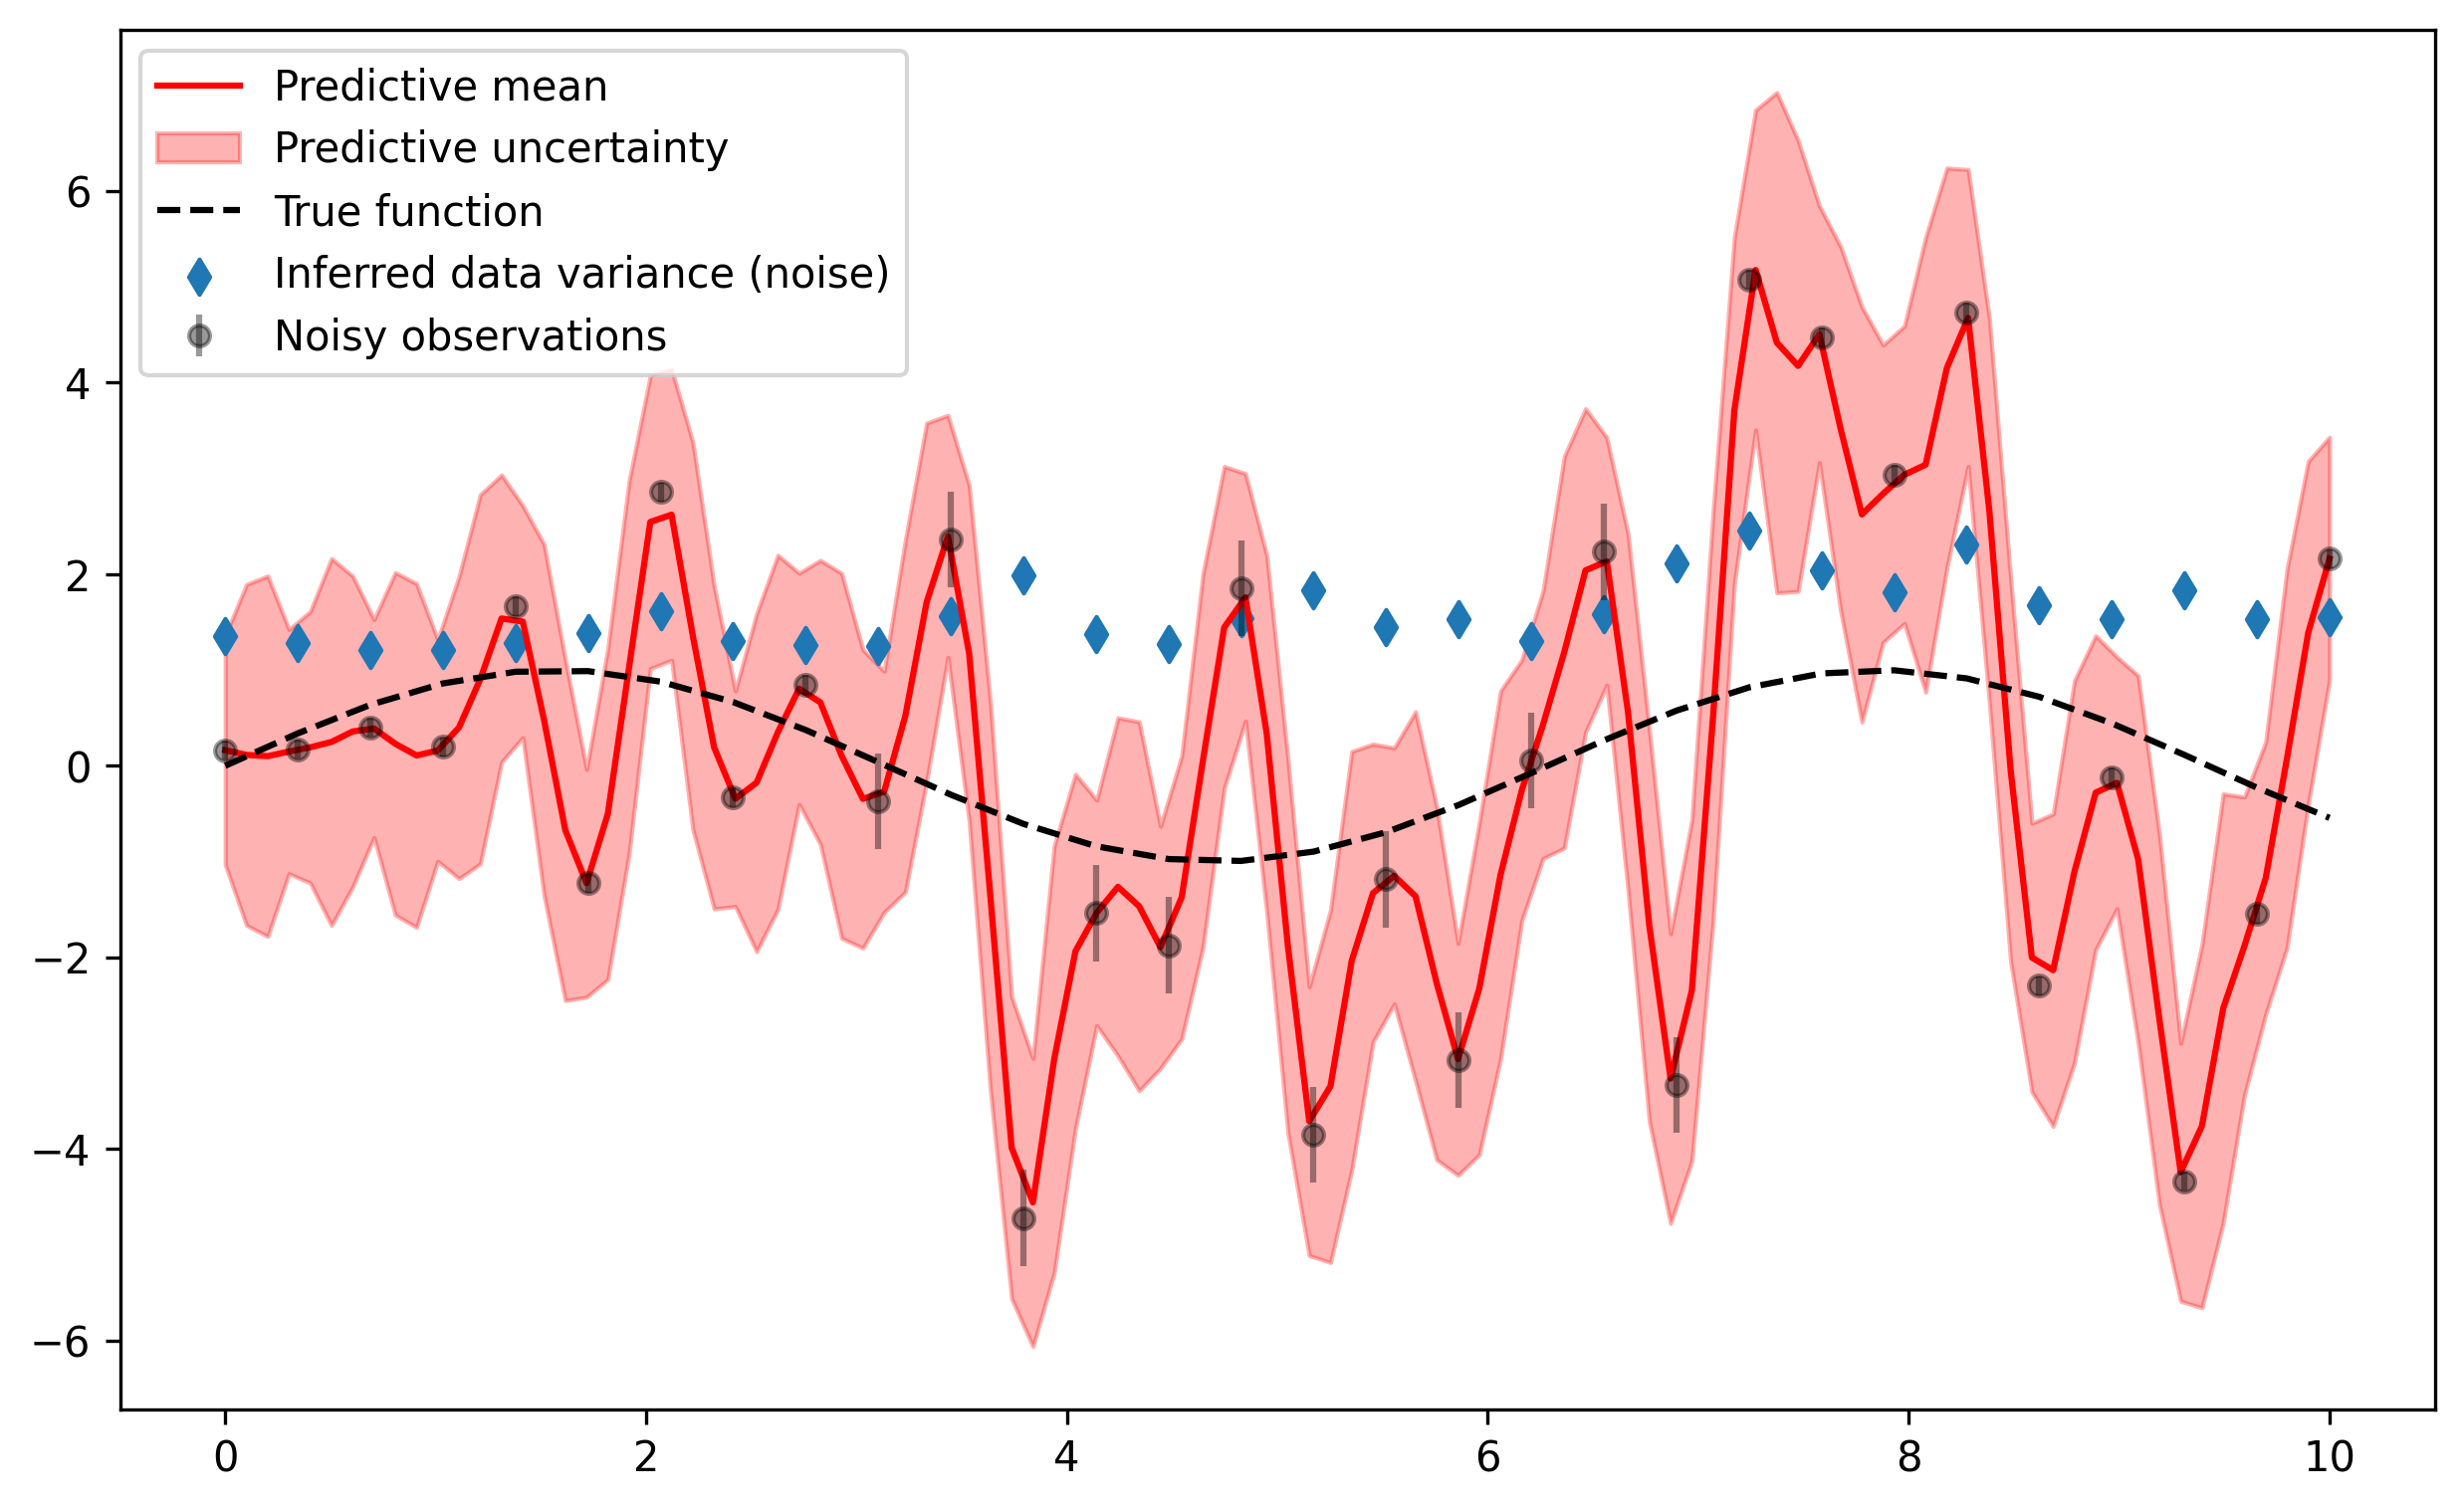

In [ ]:
lower_b = y_pred - y_sampled.std(axis=(0,1))
upper_b = y_pred + y_sampled.std(axis=(0,1))

plt.figure(figsize=(10, 6), dpi=300)

plt.plot(X_test, y_pred, c='r', label='Predictive mean')
plt.fill_between(X_test, lower_b, upper_b, color='r', alpha=0.3, label="Predictive uncertainty")

plt.errorbar(X.squeeze(), y_noisy.squeeze(), noise_level, fmt='.', c='k', markersize=10, alpha=0.4, label='Noisy observations')
plt.plot(X, y_true, '--', c='k', label='True function')

plt.scatter(X, data_variance, marker='d', label='Inferred data variance (noise)')

plt.legend(loc='best')

Let's set priors on both data kernel and noise kernel:

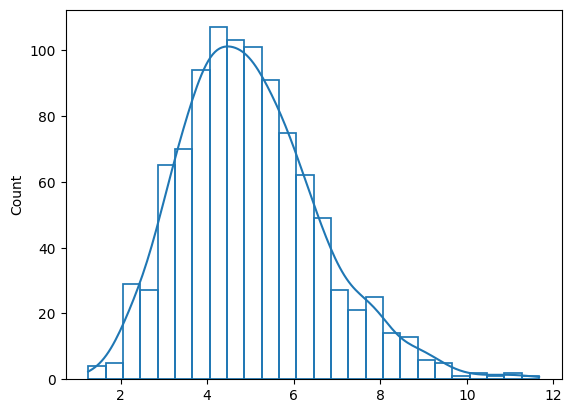

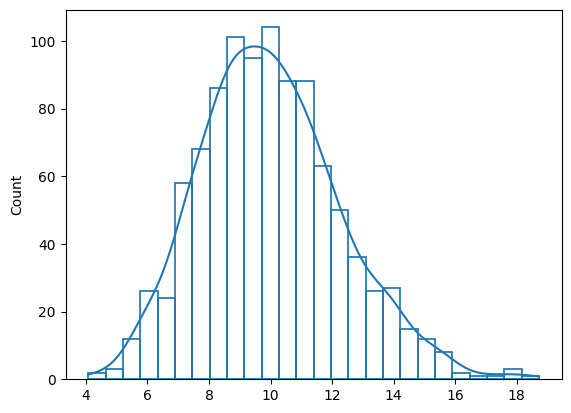

In [ ]:
lscale_prior = dist.Gamma(10, 2)
noise_lscale_prior = dist.Gamma(20, 2)

gpax.utils.dviz(lscale_prior)
gpax.utils.dviz(noise_lscale_prior)

Re-run GP

In [ ]:
key1, key2 = get_keys()

model = hskGP(1, 'RBF',
              lengthscale_prior_dist=lscale_prior,
              noise_lengthscale_prior_dist=noise_lscale_prior)

model.fit(key1, X, y_noisy, num_warmup=2000, num_samples=2000)

sample: 100%|██████████| 4000/4000 [04:31<00:00, 14.75it/s, 1023 steps of size 1.80e-03. acc. prob=0.81]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_length[0]      4.85      1.57      4.71      2.46      7.51    307.92      1.00
  k_noise_length      9.54      1.87      9.33      6.49     12.36    122.27      1.00
   k_noise_scale      1.50      0.63      1.40      0.48      2.39    153.45      1.00
         k_scale      0.81      0.88      0.54      0.07      1.70    266.17      1.01



Note that the ```r_hat``` values are now much better indicating a proper MCMC convergence.

In [ ]:
X_test = np.linspace(0, 10, 100)

y_pred, y_sampled = model.predict(key2, X_test)

data_variance = model.get_data_var_samples().mean(0)

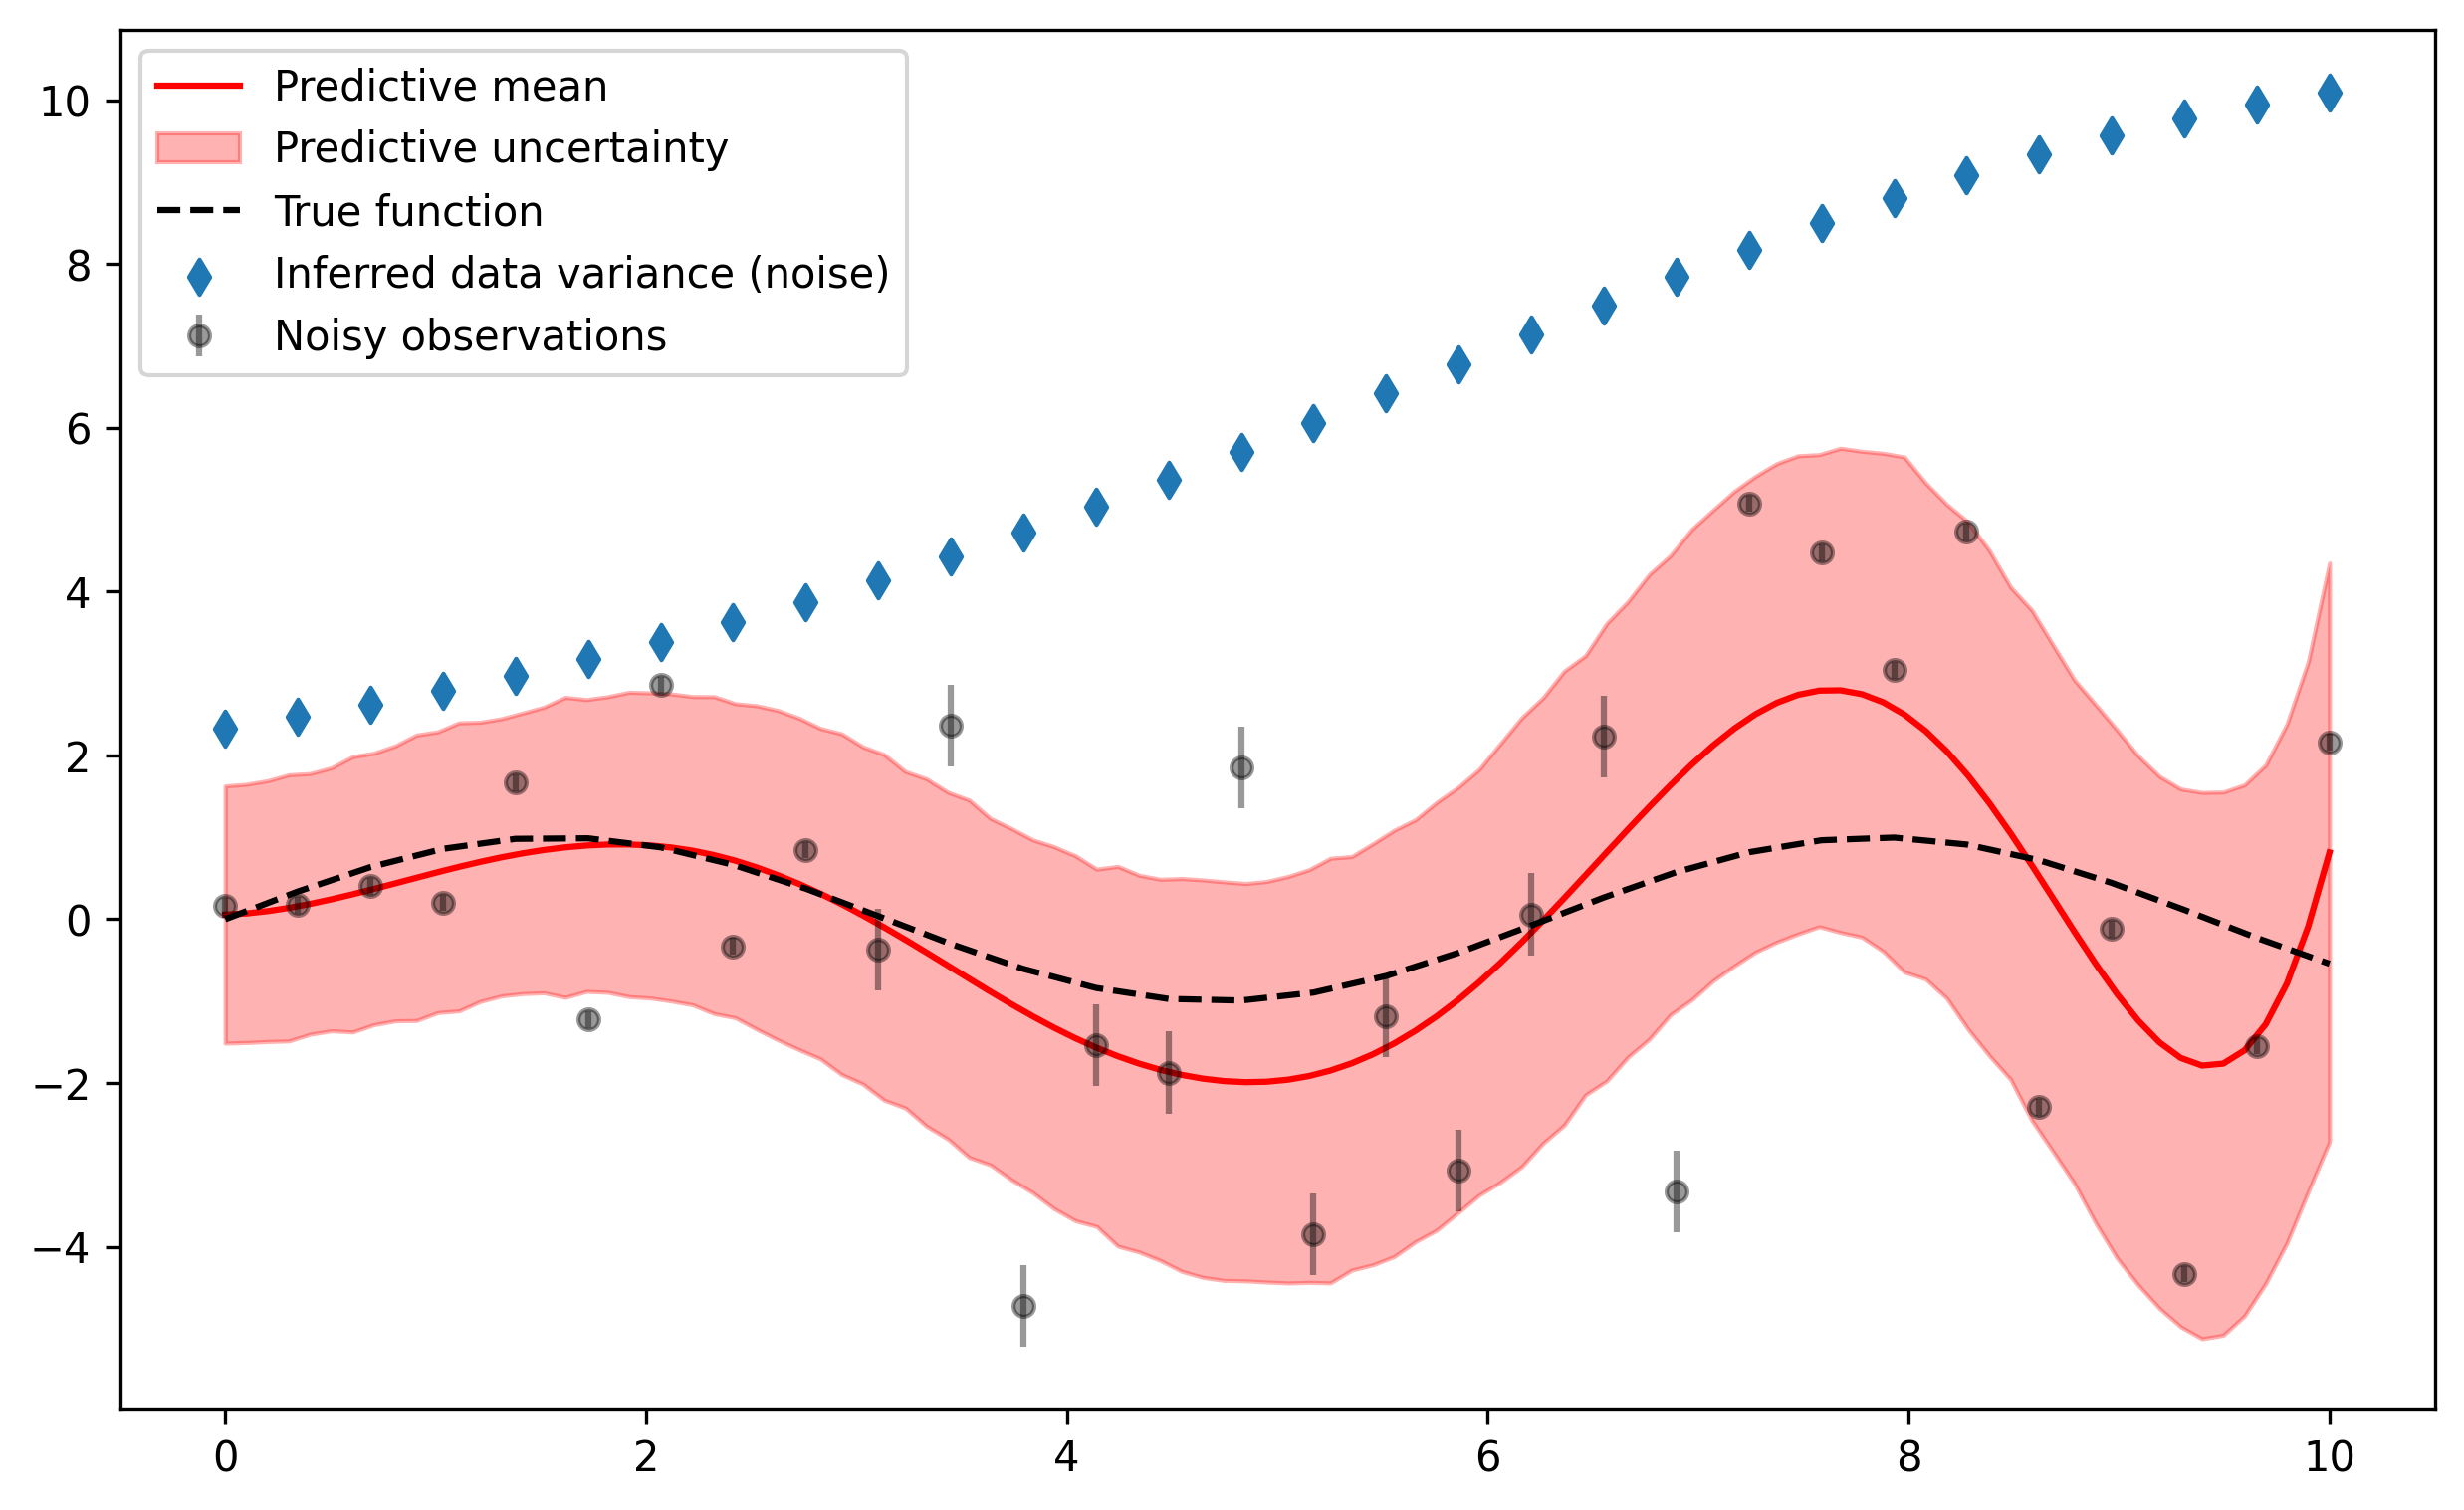

In [ ]:
lower_b = y_pred - y_sampled.std(axis=(0,1))
upper_b = y_pred + y_sampled.std(axis=(0,1))

plt.figure(figsize=(10, 6), dpi=300)

plt.plot(X_test, y_pred, c='r', label='Predictive mean')
plt.fill_between(X_test, lower_b, upper_b, color='r', alpha=0.3, label="Predictive uncertainty")

plt.errorbar(X.squeeze(), y_noisy.squeeze(), noise_level, fmt='.', c='k', markersize=10, alpha=0.4, label='Noisy observations')
plt.plot(X, y_true, '--', c='k', label='True function')

plt.scatter(X, data_variance, marker='d', label='Inferred data variance (noise)')

plt.legend(loc='best')